##### Set up packages and directories

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
from tqdm.auto import tqdm
from Comparative_Analysis import Sequence_Analysis_Routines as sar
from Comparative_Analysis import Utilities as util
from Comparative_Analysis import Alignment as align
import random
import copy
from joblib import Parallel, delayed
import os
import subprocess
from Bio.Blast import NCBIWWW, NCBIXML

In [ ]:
project_dir = 'D:/Project_Data/Project_6'
literature_datasets_dir = project_dir + '/Datasets/Data_From_Publications'
output_dir = project_dir + '/Output'
refseq_dir = 'D:/Test_3/NCBI_Dataset_Mycobacteria'
cryptic_output_path = "D:/Project_Data/CRYPTIC_DATA/Cryptic_Data_Analysis"
num_cores = 16
core_numbers = list(range(1, num_cores+1))

In [ ]:
species_list = util.list_dirs(refseq_dir)
reference_species = 'GCF_000195955.2'
#species_list = species_list[4:6]    #For testing
species_list_excl_ref = [x for x in species_list if x!= reference_species]

In [ ]:
min_nts = 60

##### Translation function

In [ ]:
codon_dict = {}
with open('D:/Project_Data/Project_3/Datasets/Reference_Tables/Standard_Code.txt') as f:
    for l in f:
        codon_dict[str(l[1:4])] = l[5]
def translate_sequence(input_seq, strand, rf):
    output_seq = ''
    if strand == 1:
        seq = input_seq[rf:]
    else:
        seq = align.reverse_complement(input_seq)[rf:]
    for i in range(0,len(seq)-2,3):
        if seq[i:(i+3)] in codon_dict:
            output_seq += codon_dict[seq[i:(i+3)]]
        else:
            output_seq += 'X'
    return output_seq

In [ ]:
def translate_orf(sequence, start, end, strand):
    return translate_sequence(sequence[start:end], strand, 0)              

##### Output nt sequences in FASTA format

In [ ]:
def produce_blast_file(record_list, output_filename):
    with open(output_filename, 'w',  newline='') as outfile:
        line_length = 60
        for record in tqdm(record_list):
            sequence = record[1]
            lines = []
            sequence_length = len(sequence)
            number_of_lines = math.ceil(sequence_length / line_length)
            lines.append(">" +record[0]+ "\n")
            for i in range(number_of_lines):
                subsequence = sequence[i*line_length:(i+1)*line_length]
                lines.append(subsequence + "\n")
            outfile.write(''.join(lines))

##### Function to find maximal open reading frame between two co-ordinates with mutation probability less than defined p-value

In [ ]:
def find_all_maximal_orfs(sequence, seq_start, seq_stop, output_all_orfs = False, min_orf_length = 0):
    max_len = 0
    orfs_found = []
    start_pos = -999
    end_pos = -999
    for frame in ['Forward', 'Reverse']:
        if frame == 'Forward':
            temp = (sequence[seq_start: seq_stop])
        else:
            temp = align.reverse_complement(sequence[seq_start: seq_stop])
        seq_len = len(temp)
        for rf in range(3):
            i = rf
            while i < seq_len - 2:
                orf_length = 0
                test_codon = temp[i: i+3] 
                if test_codon in ['ATG','GTG','TTG']:  
                    for j in range(i + 3, seq_len - 2, 3):
                        test_codon_2 = temp[j: j+3] 
                        if test_codon_2 in ['TAG','TGA','TAA']:
                            orf_length = j - i
                            break
                            
                if orf_length > 0:
                    if frame == 'Forward':
                        orf_start =  seq_start + i
                        orf_end = seq_start + j+3
                        orf_strand = 1
                    else:
                        orf_start =  seq_start + seq_len-(j+3)
                        orf_end = seq_start + seq_len-i
                        orf_strand = -1
                    
                    if orf_length >= min_orf_length:
                        orfs_found.append((orf_start, orf_end, orf_strand, orf_length))

                if orf_length > max_len and orf_length >= min_orf_length:                                           
                    max_len = orf_length
                    start_pos = orf_start
                    end_pos = orf_end
                    strand = orf_strand 

                if orf_length > 0:
                    i = j
                else:
                    i +=3
    if output_all_orfs == True:
        sorted_orfs = sorted(orfs_found, key=lambda x: x[3], reverse=True)
        return sorted_orfs                
    elif start_pos == -999:
        return(0,0,0,0)
    else:
        return(start_pos, end_pos, strand, max_len)   

##### Function to find nearest upstream start to an alignment making it an open reading frame

In [ ]:
def find_nearest_upstream_orf_sequence(sequence, seq_start, seq_stop, strand, max_lookback = 100):
    out_seq = ''
    if strand == 1:
            temp = (sequence[seq_start - max_lookback * 3: seq_stop])
    else:
            temp = align.reverse_complement(sequence[seq_start: seq_stop + max_lookback * 3])
    for lookback in range(max_lookback, -1, -1):
        if temp[lookback * 3: (lookback+1) *3 ] in ['TAG','TGA','TAA']:
            #  Not possible without first encountering stop - just return original sequence
            out_seq = translate_sequence(temp[max_lookback * 3:],1,0)
            break
        if temp[lookback * 3: (lookback+1) *3 ] in ['ATG','GTG','TTG']:
            out_seq = translate_sequence(temp[lookback * 3:],1,0)
            break
    return(out_seq)   

In [ ]:
def find_nearest_downstream_orf_sequence(sequence, seq_start, seq_stop, strand):
    max_lookforward = max(1, int((seq_stop - seq_start) / 3) - 4)
    out_seq = ''
    if strand == 1:
            temp = sequence[seq_start:seq_stop]
    else:
            temp = align.reverse_complement(sequence[seq_start:seq_stop])
    for lookback in range(max_lookforward):
        if temp[lookback * 3: (lookback+1) *3 ] in ['TAG','TGA','TAA']:
            #  Not possible without first encountering stop - just return original sequence
            out_seq = translate_sequence(temp,1,0)
            break
        if temp[lookback * 3: (lookback+1) *3 ] in ['ATG','GTG','TTG']:
            out_seq = translate_sequence(temp[lookback * 3:],1,0)
            break
    return(out_seq)   

#####  Function to process output from BLAST into dataframe with looked up values

In [ ]:
def process_blast_output(infile_loc, outfile_loc):
    blast_results = pd.read_csv(infile_loc, header = None)
    blast_results.columns = ['query_accession_ver', 'subject_accession_ver', 'query_length', 'subject_length', 'percent_identical_matches','alignment_length', 'number_mismatches', 'number_of_gap_openings', 'query_start_alignment', 'query_end_alignment', 'subject_start_alignment', 'subject_end_alignment', 'e_value', 'bit_score']
    blast_results['query_info']=  blast_results['query_accession_ver'].map(protein_reference_dict)
    blast_results['subject_info']=  blast_results['subject_accession_ver'].map(protein_reference_dict)
    blast_results['query_feature']=  blast_results['query_accession_ver'].map(orf_feature_dict)
    blast_results['subject_feature']=  blast_results['subject_accession_ver'].map(orf_feature_dict)
    for i, r in blast_results.iterrows():
        blast_results.at[i, 'query_species'] = '_'.join(r.query_accession_ver.split('_')[0:2])
        blast_results.at[i, 'subject_species'] = '_'.join(r.subject_accession_ver.split('_')[0:2])
    blast_results = blast_results.query('not (query_species == subject_species)')
    blast_results['query_species_name'] = blast_results['query_species'].map(names_dict)
    blast_results['subject_species_name'] = blast_results['subject_species'].map(names_dict)
    for i, r in blast_results.iterrows():
        if r.query_info[2] == 1:
            blast_results.at[i, 'query_start_pos'] = r.query_info[0] + (r.query_start_alignment - 1) * 3
            blast_results.at[i, 'query_end_pos'] = r.query_info[0] + (r.query_end_alignment - 1) * 3 + 6 # doesn't include stop codon in blast
        else:
            blast_results.at[i, 'query_start_pos'] = r.query_info[1] - (r.query_end_alignment) * 3
            blast_results.at[i, 'query_end_pos'] = r.query_info[1] - (r.query_start_alignment - 1) * 3

        if r.subject_info[2] == 1:
            blast_results.at[i, 'subject_start_pos'] = r.subject_info[0] + (r.subject_start_alignment - 1) * 3
            blast_results.at[i, 'subject_end_pos'] = r.subject_info[0] + (r.subject_end_alignment - 1) * 3 + 6 # doesn't include stop codon in blast
        else:
            blast_results.at[i, 'subject_start_pos'] = r.subject_info[1] - (r.subject_end_alignment) * 3
            blast_results.at[i, 'subject_end_pos'] = r.subject_info[1] - (r.subject_start_alignment - 1) * 3
    blast_results = blast_results.loc[blast_results.groupby(['query_accession_ver','subject_species'])['bit_score'].idxmax()]
    blast_results['species_count'] = blast_results.groupby('query_accession_ver')['query_accession_ver'].transform('size')
    for i, r in blast_results.iterrows():
        subject_strand = r.subject_info[2]
        blast_results.at[i,'sequence'] = translate_orf(myco_info_dict[r.subject_species][1], int(r.subject_start_pos), int(r.subject_end_pos), subject_strand)
        blast_results.at[i,'nearest_upstream_orf_sequence'] = find_nearest_upstream_orf_sequence(myco_info_dict[r.subject_species][1], int(r.subject_start_pos), int(r.subject_end_pos), subject_strand, max_lookback = 100)
        blast_results.at[i,'nearest_downstream_orf_sequence'] = find_nearest_downstream_orf_sequence(myco_info_dict[r.subject_species][1], int(r.subject_start_pos), int(r.subject_end_pos), subject_strand)
    blast_results.to_csv(outfile_loc)
    return blast_results

In [ ]:
def keep_reciprocal_best_hits(query_df, reverse_query_df, outfile_loc):
    temp_1_dict = {}
    temp_2_dict = {}
    for i, r in query_df.iterrows():
        temp_1_dict[r['query_accession_ver']] = r['subject_accession_ver']
    for i, r in reverse_query_df.iterrows():
        temp_2_dict[r['query_accession_ver']] = r['subject_accession_ver']
    for i, r in query_df.iterrows():
        if temp_1_dict[r['query_accession_ver']] in temp_2_dict and temp_2_dict[temp_1_dict[r['query_accession_ver']]] == r['query_accession_ver']:
            query_df.at[i, 'reciprocal_best_hit'] = 'Y'
        else:
            query_df.at[i, 'reciprocal_best_hit'] = 'N'
    output = query_df[query_df.reciprocal_best_hit == 'Y'] 
    output.to_csv(outfile_loc)
    return output

##### Extract full sequences from each organism and create directory of start and stops for each annotated cds (use Mycobrowser for MTb)

In [ ]:
def generate_myco_info(num_subsets, subset_num, species_master_list):
    output = []
    species_list = util.chunk_list(species_master_list, num_subsets, subset_num)
    for species in species_list:
        features = []
        genome_record = next(SeqIO.parse(refseq_dir + '/'+species+'/genomic.gbff', "genbank"))
        full_sequence = str(genome_record.seq)
        if full_sequence.count('A') + full_sequence.count('C') + full_sequence.count('G') + full_sequence.count('T') < len(full_sequence):
            continue
        organism = genome_record.annotations['organism']
        
        #  Read feature information
        if species == reference_species:
            mycobrowser_df = pd.read_excel(literature_datasets_dir+'/Mycobrowser_Release_4.xlsx')
            for i, r in mycobrowser_df.iterrows():
                if r['Strand'] == '+':
                    strand = 1
                else:
                    strand = -1
                features.append((r['Locus'],r['Start']-1, r['Stop'], strand))
            
        else:
            
            for feature in genome_record.features:
                    a = feature.qualifiers
                    if a.get("locus_tag")!= None and int(feature.location.end) - int(feature.location.start) < 100000:  #  Exclude strange Biopython parsing where starts with complement join and looks like a CDS is full length of genome!    and feature.type == 'CDS':
                        locus_tag = a.get("locus_tag")[0]
                        features.append([locus_tag, int(feature.location.start), int(feature.location.end), int(feature.location.strand)])
        
        features.sort(key=lambda x: x[1])
        #  Find maximal orfs, non-overlapping orfs and their protein sequences, and assign a reference to each
        maximal_orfs = find_all_maximal_orfs(full_sequence, 0, len(full_sequence), True, min_nts)
        
        protein_references = []
        maximal_orf_proteins = []
        orf_feature_map = []
        non_overlapping_maximal_orfs = []
        non_overlapping_maximal_orf_proteins = []
        non_overlapping_orfs = []
        non_overlapping_orf_proteins = []
        for i, orf in enumerate(maximal_orfs):
            translation = translate_orf(full_sequence, orf[0], orf[1], orf[2])[:-1]
            morf_name = species+'_'+str(i)
            maximal_orf_proteins.append([morf_name, translation])
            protein_references.append((morf_name, orf))
            overlap = False
            for cds in features:
                if orf[0] <= cds[1] and orf[1] >= cds[2] and orf[2] == cds[3]:
                    orf_feature_map.append((morf_name, cds[0]))
                if min(cds[2], orf[1]) - max(cds[1], orf[0]) > 0.3 * (orf[1] - orf[0]):
                    overlap = True
                    break
            if overlap == False:
                nomorf_name = species+'_NOM_'+str(i)
                non_overlapping_maximal_orfs.append(orf)
                non_overlapping_maximal_orf_proteins.append([nomorf_name, translation])
                protein_references.append((nomorf_name, orf))
        
        non_overlapping_features = []

        for i, cds in enumerate(features):
            if i > 0 and cds[2] > features[i-1][2]:
                non_overlapping_features.append(cds)
        for i, cds in enumerate(non_overlapping_features):
            if i < len(non_overlapping_features) - 1:
                temp = find_all_maximal_orfs(full_sequence, cds[2], non_overlapping_features[i+1][1], True, min_nts)
                for orf in temp:
                    non_overlapping_orfs.append(orf)
        for i, orf in enumerate(non_overlapping_orfs):
            translation = translate_orf(full_sequence, orf[0], orf[1], orf[2])[:-1]
            noorf_name = species+'_NO_'+str(i)
            non_overlapping_orf_proteins.append([noorf_name, translation])
            protein_references.append((noorf_name, orf))
            
        output.append((species, organism, full_sequence, features, maximal_orfs, non_overlapping_maximal_orfs, maximal_orf_proteins, non_overlapping_maximal_orf_proteins, protein_references, orf_feature_map, non_overlapping_orfs, non_overlapping_orf_proteins))
    return output

In [ ]:
myco_info_dict = {}
names_dict = {}
parallel_output = Parallel(n_jobs=-1)(delayed(generate_myco_info)(num_cores, core_number, species_list) for core_number in core_numbers)
for core_output in parallel_output:
    for results in core_output:
        myco_info_dict[results[0]] = (results[1], results[2], results[3], results[4], results[5], results[6], results[7], results[8], results[9], results[10], results[11])
        names_dict[results[0]] = results[1]

In [ ]:
orf_feature_dict = {}
protein_reference_dict = {}
orf_protein_dict = {}
for species in species_list:
    for ref in myco_info_dict[species][7]:
        protein_reference_dict[ref[0]] = ref[1]
        orf_protein_dict[(species, ref[1])] = ref[0]
    for ref in myco_info_dict[species][8]:
        orf_feature_dict[ref[0]] = ref[1]

##### Output two blast files - one (subject) containing all translated mORFs, the other (query) just the ones for the reference species 

In [ ]:
subject_protein_list = []
for species in species_list_excl_ref:
    for maximal_orf_protein in myco_info_dict[species][5]:
        subject_protein_list.append(maximal_orf_protein)
produce_blast_file(subject_protein_list, refseq_dir + '/subject_proteins.faa')

query_protein_list = myco_info_dict[reference_species][6]
produce_blast_file(query_protein_list, refseq_dir + '/no_overlap_morf_query_proteins.faa')

query_protein_list = myco_info_dict[reference_species][10]
produce_blast_file(query_protein_list, refseq_dir + '/no_overlap_orf_query_proteins.faa')

query_protein_list = myco_info_dict[reference_species][5]
produce_blast_file(query_protein_list, refseq_dir + '/morf_query_proteins.faa')

##### Create blast databases

In [ ]:
if 1==0:
    w_d = os.getcwd()
    os.chdir("D:/")
    subprocess.run('cd '+ refseq_dir + ' &  makeblastdb -in subject_proteins.faa -dbtype prot -out subj_prot', shell=True, capture_output = True)
    subprocess.run('cd '+ refseq_dir + ' &  makeblastdb -in morf_query_proteins.faa -dbtype prot -out query_prot', shell=True, capture_output = True)
    subprocess.run('cd '+ refseq_dir + ' &  makeblastdb -in no_overlap_morf_query_proteins.faa -dbtype prot -out no_overlap_morf_query_prot', shell=True, capture_output = True)
    subprocess.run('cd '+ refseq_dir + ' &  makeblastdb -in no_overlap_orf_query_proteins.faa -dbtype prot -out no_overlap_orf_query_prot', shell=True, capture_output = True)
    os.chdir(w_d)

In [ ]:
if 1==0:
    w_d = os.getcwd()
    os.chdir("D:/")
    subprocess.run('cd d:\\BLAST\\subj_prot & blastp -query ' + refseq_dir + '/morf_query_proteins.faa -db subj_prot -out blastp_results_query_subject.csv -evalue 1e-7 -seg no -outfmt  "10 qaccver saccver qlen slen pident length mismatch gapopen qstart qend sstart send evalue bitscore" -num_threads 16', shell=True, capture_output = True)
    subprocess.run('cd d:\\BLAST\\subj_prot & blastp -query ' + refseq_dir + '/no_overlap_morf_query_proteins.faa -db subj_prot -out blastp_results_no_morf_query_subject.csv -evalue 1e-7 -seg no -outfmt  "10 qaccver saccver qlen slen pident length mismatch gapopen qstart qend sstart send evalue bitscore" -num_threads 16', shell=True, capture_output = True)
    subprocess.run('cd d:\\BLAST\\subj_prot & blastp -query ' + refseq_dir + '/no_overlap_orf_query_proteins.faa -db subj_prot -out blastp_results_no_orf_query_subject.csv -evalue 1e-7 -seg no -outfmt  "10 qaccver saccver qlen slen pident length mismatch gapopen qstart qend sstart send evalue bitscore" -num_threads 16', shell=True, capture_output = True)

    subprocess.run('cd d:\\BLAST\\query_prot & blastp -query ' + refseq_dir + '/subject_proteins.faa -db query_prot -out blastp_results_subject_query.csv -evalue 1e-7 -seg no -outfmt  "10 qaccver saccver qlen slen pident length mismatch gapopen qstart qend sstart send evalue bitscore" -num_threads 16', shell=True, capture_output = True)
    subprocess.run('cd d:\\BLAST\\no_overlap_morf_query_prot & blastp -query ' + refseq_dir + '/subject_proteins.faa -db no_overlap_morf_query_prot -out blastp_results_subject_no_morf_query.csv -evalue 1e-7 -seg no -outfmt  "10 qaccver saccver qlen slen pident length mismatch gapopen qstart qend sstart send evalue bitscore" -num_threads 16', shell=True, capture_output = True)
    subprocess.run('cd d:\\BLAST\\no_overlap_orf_query_prot & blastp -query ' + refseq_dir + '/subject_proteins.faa -db no_overlap_orf_query_prot -out blastp_results_subject_no_orf_query.csv -evalue 1e-7 -seg no -outfmt  "10 qaccver saccver qlen slen pident length mismatch gapopen qstart qend sstart send evalue bitscore" -num_threads 16', shell=True, capture_output = True)

    os.chdir(w_d)

In [ ]:
blast_results_qs = process_blast_output('D:\\BLAST\\subj_prot\\blastp_results_query_subject.csv', project_dir + '/blast_results_qs.csv')
blast_results_sq = process_blast_output('D:\\BLAST\\query_prot\\blastp_results_subject_query.csv', project_dir + '/blast_results_sq.csv')
blast_results_nomqs = process_blast_output('D:\\BLAST\\subj_prot\\blastp_results_no_morf_query_subject.csv', project_dir + '/blast_results_nomqs.csv')
blast_results_snomq = process_blast_output('D:\\BLAST\\no_overlap_morf_query_prot\\blastp_results_subject_no_morf_query.csv', project_dir + '/blast_results_snomq.csv')
blast_results_nooqs = process_blast_output('D:\\BLAST\\subj_prot\\blastp_results_no_orf_query_subject.csv', project_dir + '/blast_results_nooqs.csv')
blast_results_snooq = process_blast_output('D:\\BLAST\\no_overlap_orf_query_prot\\blastp_results_subject_no_orf_query.csv', project_dir + '/blast_results_snooq.csv')

In [ ]:
#rbh_orf = keep_reciprocal_best_hits(blast_results_qs, blast_results_sq, project_dir + '/rbh_orf_results.csv')
#rbh_non_overlap_morf = keep_reciprocal_best_hits(blast_results_nomqs, blast_results_snomq, project_dir + '/rbh_non_overlap_morf_results.csv')
rbh_non_overlap_orf = keep_reciprocal_best_hits(blast_results_nooqs, blast_results_snooq, project_dir + '/rbh_non_overlap_orf_results.csv')

#####  Count orthologs

In [ ]:
temp = rbh_orf.query('not(query_feature.isnull()) and not(subject_feature.isnull())')
temp.groupby('subject_species_name').count().to_csv(project_dir + '/reciprocal_ortholog_counts.csv')

#####  Identify commonly preserved mORFs in non-overlapping areas

In [ ]:
temp = rbh_non_overlap_orf[rbh_non_overlap_orf.species_count > 10]
temp.to_csv(project_dir + '/preserved_noorfs.csv')

In [ ]:
temp = rbh_non_overlap_orf[rbh_non_overlap_orf.species_count >= 70]

temp = temp.drop_duplicates(['query_accession_ver','species_count','query_info'])[['query_accession_ver','species_count','query_info']]

In [ ]:
len(temp)

In [ ]:
temp

In [ ]:
sns.histplot(data = temp, x = 'species_count', bins = 100)

In [ ]:
feature_orf_dict = {}
for k, v in orf_feature_dict.items():
    feature_orf_dict[v] = k

In [115]:
temp_df = pd.DataFrame(list(names_dict.items()), columns = ['Name','Value'])
temp_df.to_csv(project_dir + '/namedict.csv')

In [136]:
df_list = []
close_species_list = ['GCF_000009445.1', 'GCF_000157895.3','GCF_000195955.2','GCF_000253375.1', 'GCF_000157895.3', 'GCF_003584745.1', 'GCF_003614435.1', 'GCF_010728525.1', 'GCF_010730055.1' , 'GCF_010731535.1', 'GCF_013466425.1', 'GCF_016745295.1', 'GCF_018278905.1', 'GCF_900292015.1', 'LT_708304.1']
close_species_df = rbh_orf.query('subject_species in @close_species_list')
for i, feature in enumerate(myco_info_dict[reference_species][2]):
    if i<100:
        continue
    if i > 200:
        break
    strand = feature[3]
    name = feature[0]
    if strand == 1:
        start = feature[1]
    else:
        start = feature[2]
        
    if not (feature[0] in feature_orf_dict):
        pass
    else:
        df = close_species_df.query('query_feature == @feature[0]')[['query_feature', 'query_start_pos', 'query_end_pos']]
        if len(df) > 5:
            if strand == 1:
                df['offset'] = (df['query_start_pos'] - start)/3 
            else:
                df['offset'] = (start - df['query_end_pos'])/3
            df_list.append(df)
temp = pd.concat(df_list)

<Figure size 360x360 with 0 Axes>

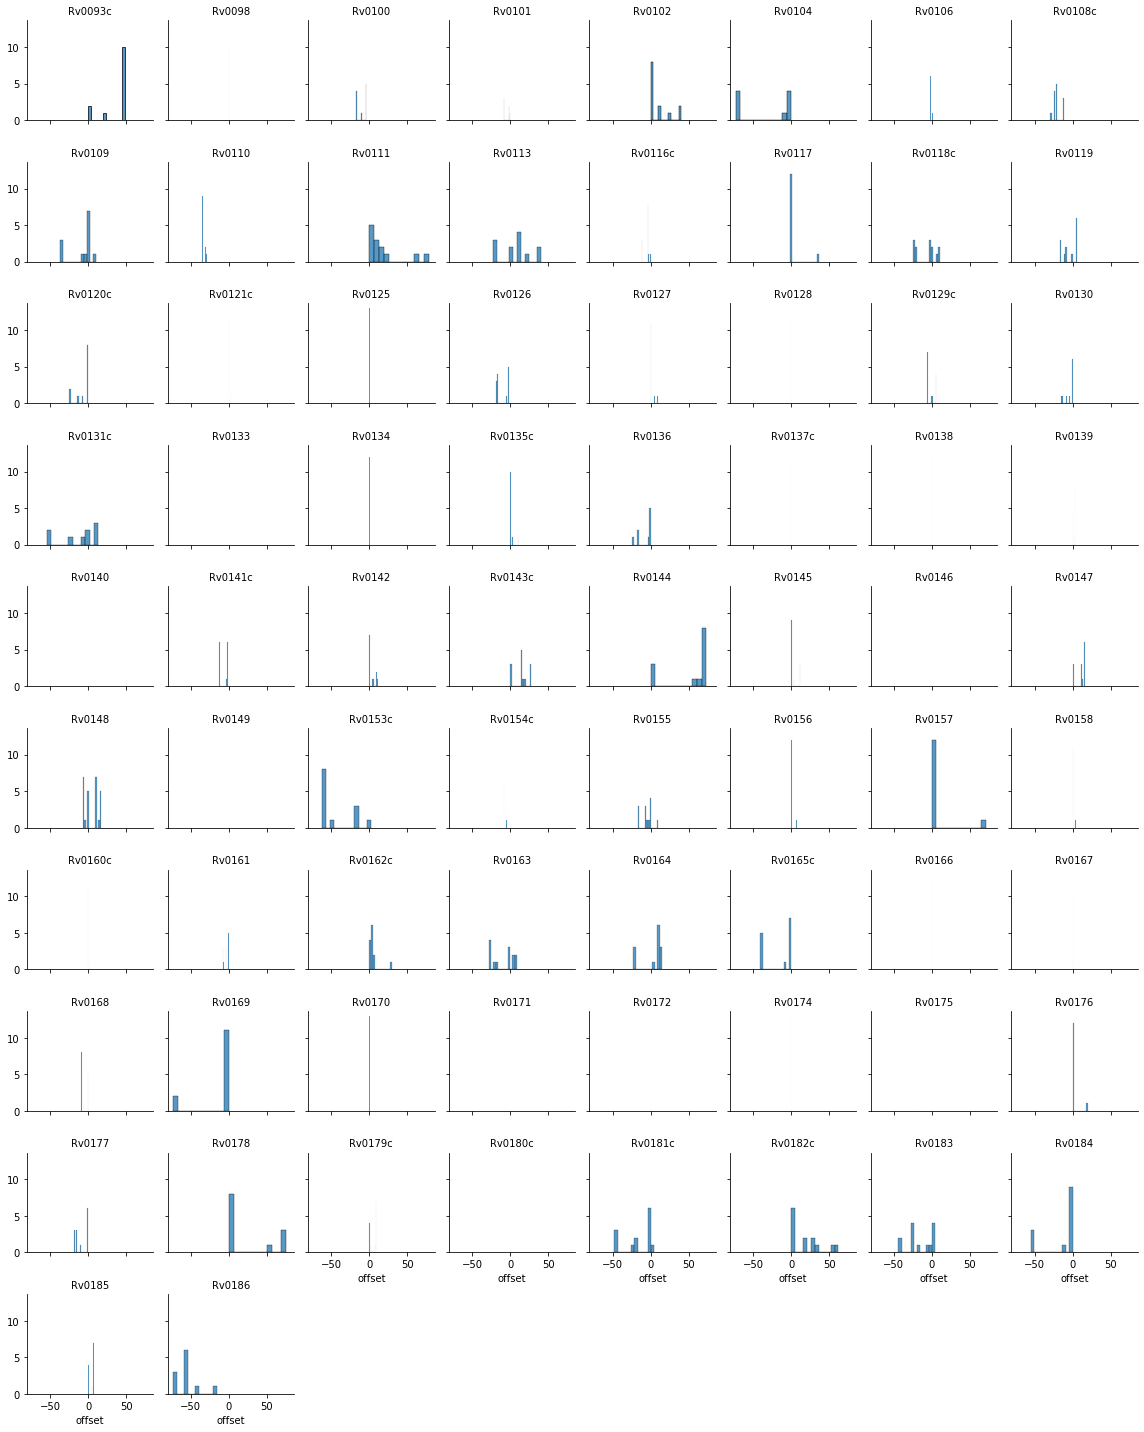

In [138]:
temp = temp.query('offset > -80 and offset < 80')
plt.figure(figsize=(5, 5))
g = sns.FacetGrid(temp, col='query_feature', height=2, col_wrap=8)
g.map(sns.histplot, 'offset', bins=12)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

##### Violin plots

In [ ]:
temp[temp['query_feature'] == 'Rv0003']

In [ ]:
plt.figure(figsize=(12, 12))
g = sns.FacetGrid(rbh_orf, col='subject_species_name', height=5, col_wrap=3)
g.map(sns.scatterplot, 'subject_start_pos', 'query_start_pos', s=2)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

##### Load variant dataset and create variant dictionary (0 indexed for genome position - whereas CRyPtiC data uses 1 start)

In [ ]:
variant_count_df = pd.read_csv(cryptic_output_path + '/filtered_variant_summary_df.csv')
variant_count_df = variant_count_df[variant_count_df['MUTATION_PCT'] < 0.1]

In [ ]:
temp = variant_count_df.groupby(['GENOME_INDEX'])[['MYKROBE_LINEAGE_NAME_2']].count().reset_index()
temp_dict = dict(zip(temp.GENOME_INDEX, temp.MYKROBE_LINEAGE_NAME_2))

In [ ]:
mutation_counts_dict = {}
for i in tqdm(range(len(myco_info_dict[reference_species][1]))):
    if (i+1) in temp_dict:
        mutation_counts_dict[i] = temp_dict[(i+1)]
    else:
        mutation_counts_dict[i] = 0

##### Define binomial probabilities for testing mutation counts

In [ ]:
def bin_formula(max_bin_counts, tot_bin_counts, in_frame = False):
    return 1- binom.cdf(max_bin_counts-1, tot_bin_counts,1/3)

In [ ]:
def mutation_bin_probability(start, end, strand):
    mutations = []
    for i in range(start,end):
        for j in range(mutation_counts_dict[i]):
            mutations.append(i)
    bin_counts = [0,0,0]
    for m in mutations:
        if strand == 1:
            bin_counts[(m-(start))%3] +=1
        else:
            bin_counts[((end-1)-m)%3] +=1
    if sum(bin_counts) == 0:
        return (2)
    else:
        return (bin_formula(bin_counts[2], sum(bin_counts)))  

In [ ]:
mutation_bin_probability(1282029, 1282218,1)

In [ ]:
protein_reference_dict['GCF_000195955.2_NO_1721']


In [ ]:
for i, r in temp.iterrows():
    temp.at[i,'prob'] = mutation_bin_probability(r['query_info'][0], r['query_info'][1], r['query_info'][2])

In [ ]:
temp.to_csv(project_dir + '/norf_top_ten.csv')